# Model Evaluation

This notebook evaluates the trained models to:
- Compare performance on the validation set
- Analyze feature importance
- Visualize prediction accuracy and errors


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
from pathlib import Path
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Load datasets and model info
data_dir = Path("/tmp/models")
val_df = pd.read_csv(data_dir / "validation_dataset.csv")
with open(data_dir / "model_info.json", "r") as f:
    model_info = json.load(f)

feature_columns = model_info['feature_names']
X_val = val_df[feature_columns]
y_val = val_df['suitability_score']

print(f"Validation set shape: {val_df.shape}")


Validation set shape: (13098, 14)


## Load and Evaluate All Trained Models

We'll load each of the trained models and evaluate their performance on the validation set.

In [2]:
models_dir = Path("/tmp/models")
model_paths = {
    'RandomForest': models_dir / 'RandomForest_model.pkl',
    'XGBoost': models_dir / 'XGBoost_model.pkl',
    'GradientBoosting': models_dir / 'GradientBoosting_model.pkl'
}

results = []
for name, path in model_paths.items():
    if path.exists():
        model = joblib.load(path)
        y_pred = model.predict(X_val)
        
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mae = mean_absolute_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)
        
        results.append({'Model': name, 'RMSE': rmse, 'MAE': mae, 'R²': r2})

results_df = pd.DataFrame(results)
print("Model Performance Comparison:")
print(results_df)


Model Performance Comparison:
              Model      RMSE       MAE        R²
0      RandomForest  9.152196  4.160749  0.845019
1           XGBoost  9.124233  4.403864  0.845964
2  GradientBoosting  9.188250  4.552992  0.843795


## Best Model Analysis

Now, let's take a closer look at the best-performing model.

In [3]:
# Identify the best model from the results
best_model_name = results_df.sort_values('RMSE').iloc[0]['Model']
best_model = joblib.load(model_paths[best_model_name])
y_pred_best = best_model.predict(X_val)

print(f"Best Model: {best_model_name}")


Best Model: XGBoost


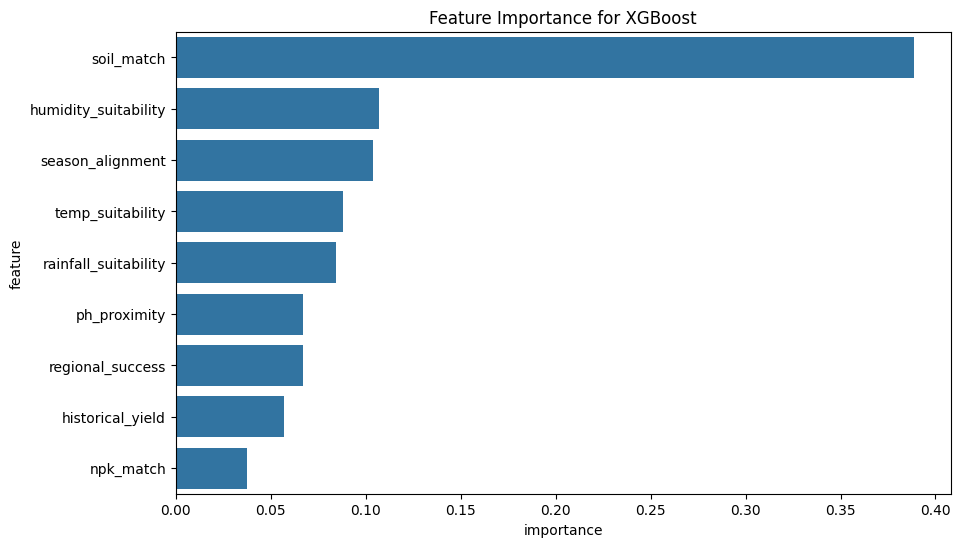

In [4]:
# Feature Importance of the Best Model
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title(f'Feature Importance for {best_model_name}')
    plt.show()


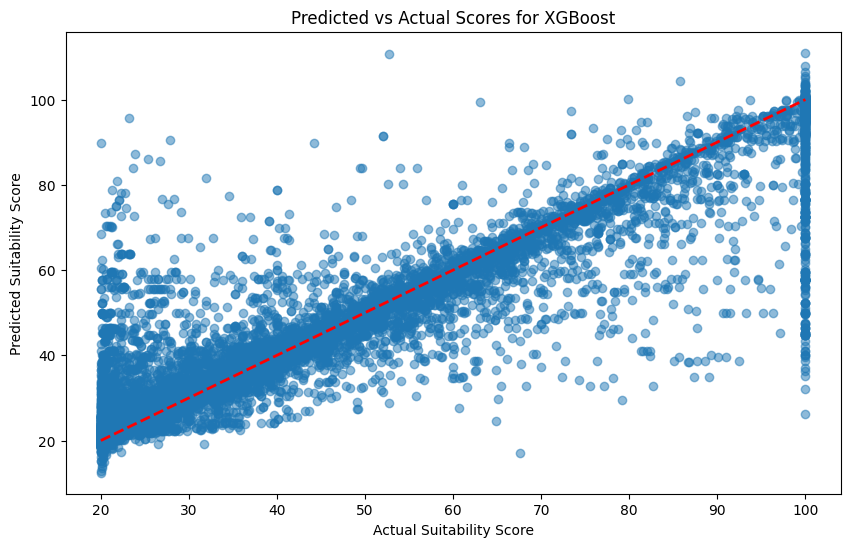

In [5]:
# Prediction vs Actual Plot for the Best Model
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_best, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Actual Suitability Score')
plt.ylabel('Predicted Suitability Score')
plt.title(f'Predicted vs Actual Scores for {best_model_name}')
plt.show()


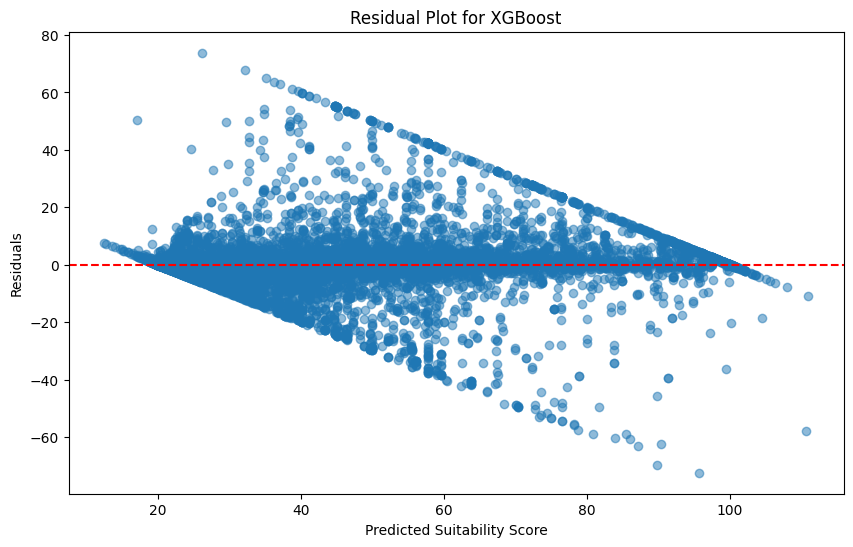

In [6]:
# Residual Plot for the Best Model
residuals = y_val - y_pred_best
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_best, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Suitability Score')
plt.ylabel('Residuals')
plt.title(f'Residual Plot for {best_model_name}')
plt.show()
